In [1]:
import pandas as pd
import numpy  as np 
import queue

import matplotlib.pyplot as plt
import statistics as stat

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting seed

SEED = 101
np.random.seed(SEED)

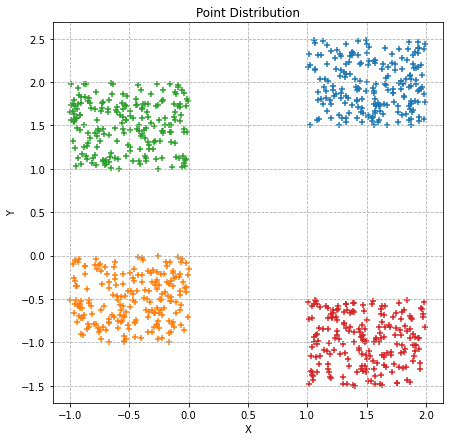

In [4]:
# Toy Dataset creation

## Creating a toy dataset

rand_values = np.random.rand(1000)

cluster_1 = np.array(list(zip( 1  + np.random.rand(200), 1.5 + np.random.rand(200))))
cluster_2 = np.array(list(zip( -1 + np.random.rand(200),  -1 + np.random.rand(200))))
cluster_3 = np.array(list(zip( -1 + np.random.rand(200),   1 + np.random.rand(200))))
cluster_4 = np.array(list(zip(  1 + np.random.rand(200),-1.5 + np.random.rand(200))))

clusters = [cluster_1, cluster_2, cluster_3, cluster_4]

## Plotting the toy dataset

fig = plt.figure(figsize=(7, 7))
for cluster in clusters:
    plt.scatter(cluster[:,0], cluster[:,1], marker='+')
plt.grid(ls='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Distribution');

## Creating the toy dataframe

toy_df = pd.DataFrame()
for cluster_id, cluster in enumerate(clusters):
    sub_df = pd.DataFrame(cluster, columns=['x', 'y'])
    sub_df['cluster_id'] = cluster_id + 1
    toy_df = pd.concat([toy_df, sub_df])

In [5]:
# Getting the dataset for unsupervised modelling

np.random.seed(101)
toy_df_unsupervised = toy_df[['x', 'y']].sample(frac=1).reset_index(drop=True)
toy_df_unsupervised = toy_df_unsupervised.values

In [6]:
# DBScan Algorithm

## Find all neighbor points in a specified radius
def get_neighbor_points(data, point_id, radius):
    neighbor_points = []
    for i in range(len(data)):
        if np.linalg.norm(data[i] - data[point_id], ord=2) <= radius:
            neighbor_points.append(i)
    return neighbor_points

## Perform DBScan algorithm

CORE = -1
EDGE = -2

def dbscan(X, epsilon, minimum_pt_threshold):
    
    ### Initialize all pointlabels
    pointlabels = [0 for x in range(len(X))]
    
    ### Find all neighbor points
    neighbor_points = [get_neighbor_points(X, point_id, epsilon) for point_id in range(len(X))]
        
    ### Find all corepoint, edgepoint and noisepoint
    core_points = []
    non_core_points = []
    
    for i in range(len(neighbor_points)):
        if len(neighbor_points[i]) >= minimum_pt_threshold:
            pointlabels[i] = CORE
            core_points.append(i)
        else:
            non_core_points.append(i)
            
    for i in non_core_points:
        for j in neighbor_points[i]:
            if j in core_points:
                pointlabels[i] = EDGE
                break
    
    ### Assigning cluster_ids to points
    cluster_id = 1
    for i in range(len(pointlabels)):
        
        core_queue = queue.Queue()
        
        if (pointlabels[i] == CORE):
            
            pointlabels[i] = cluster_id
            for j in neighbor_points[i]:
                if (pointlabels[j] == EDGE):
                    pointlabels[j] = cluster_id
                elif (pointlabels[j] == CORE):
                    pointlabels[j] = cluster_id
                    core_queue.put(j)
            
            while not core_queue.empty():
                core_point = core_queue.get()
                neighbors = neighbor_points[core_point]
                for k in neighbors:
                    if (pointlabels[k] == EDGE):
                        pointlabels[k] = cluster_id
                    elif (pointlabels[k] == CORE):
                        pointlabels[k] = cluster_id
                        core_queue.put(k)
                        
            cluster_id += 1
            
    return pointlabels

In [11]:
cluster_ids = dbscan(toy_df_unsupervised, epsilon=0.20, minimum_pt_threshold=10)
main_df = pd.concat([pd.DataFrame(toy_df_unsupervised), pd.DataFrame(cluster_ids, columns=['cluster_id'])], axis=1)
main_df.columns = ['x', 'y', 'cluster_id']

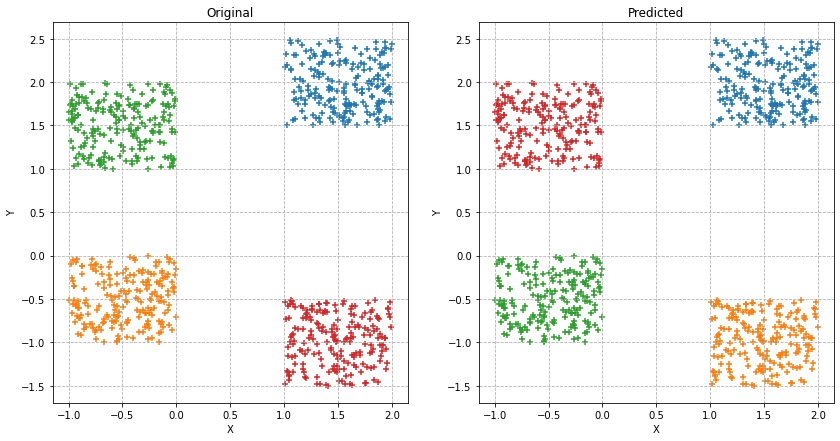

In [12]:
# Plotting Original vs Predicted for DBScan

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for _, data in toy_df.groupby('cluster_id'):
    axs[0].scatter(data['x'], data['y'], marker='+')
    axs[0].set_title("Original")
    axs[0].grid(ls='--')
    axs[0].set_ylabel('Y')
    axs[0].set_xlabel('X')

for _, data in main_df.groupby('cluster_id'):
    axs[1].scatter(data['x'], data['y'], marker='+')
    axs[1].set_title("Predicted")
    axs[1].grid(ls='--')
    axs[1].set_ylabel('Y')
    axs[1].set_xlabel('X')

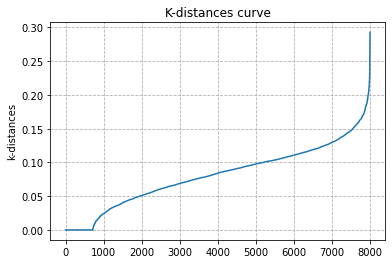

In [9]:
# Finding the optimal epsilon

def get_k_distances(data, k):
    dim0 = data.shape[0]
    dim1 = data.shape[1]
    squared_distances = -2*data.dot(data.T) + np.sum(data**2, axis=1).T \
                          + np.repeat(np.sum(data**2, axis=1), dim0, axis=0).reshape(dim0, dim0)
    euclidean_distances = np.sqrt(squared_distances)
    euclidean_distances.sort(axis=1)
    kdistances = euclidean_distances[:,:k].flatten()
    kdistances = np.sort(kdistances)
    return kdistances

kdistances = get_k_distances(toy_df_unsupervised, 10)
plt.plot(kdistances)
plt.ylabel("k-distances")
plt.grid(ls='--')
plt.title('K-distances curve')
plt.show()

In [ ]:
# TODO : DBScan v/s KMeans - Find datasets and reason